In [ ]:
#make a 2 bit adder bdd
#synthesise crossbar from it
#calculate its HRS and LRS ranges
#make it work for U.Albany team

In [1]:
import numpy as np
import sympy
from sympy import symbols, Eq, linear_eq_to_matrix
import random
import matplotlib.pyplot as plt
from collections import deque, defaultdict
# from pyeda.inter import expr, exprvar, expr2bdd
from dd.autoref import BDD
import networkx as nx
from matplotlib.colors import ListedColormap
import itertools
import pandas as pd
from sympy.logic.boolalg import SOPform
import re
import pickle
import datetime
import time
import scipy.sparse as sp
import scipy.sparse.linalg as spla
from itertools import product
import seaborn as sns
import math

# change the code to save the data in sqlite database or pickle file to store the results
    # store number of devices in each path
    # Store currents in each path for future plots

#make code run in hipergator

#run upto 3-bit adder for optimal solution with 10 iterations and generate graphs

#############################################################################

#find and pinpoint cases that get only max zeros and min ones current

# 1 - (number of devices)
# 0 - (neighbour lrs devices to ground)
# run the simulation for only those special cases

In [2]:
class PATH:
    def __init__(self, CrossbarGridSize = 16):
        self.CrossbarGridSize = CrossbarGridSize
        self.Crossbar_sizes = [2**i for i in range(3,16)]

        self.pre_bool_expressions = None
        self.pre_varibles_lst = None
        self.nodeID_map = None

        self.filename = None
        self.model_name = None
        self.inputs = []
        self.outputs = []

        self.OriginalTruthTable = None
        self.TruthTable = None
        
        self.BDD = None
        self.Graph = None
        self.Expressions = None
        self.NodeIDMap = None
        self.InputNode = None
        self.GraphProcessPhase = None
        self.CrossbarResistiveStates = None
        self.Bitlines = None
        self.SBDD_dimentions = None

        self.TreeMapInNodes = {}
        self.xlabelsOfLiterals_map = {}
        self.OutputLine_Map = {}
        self.AllIdealPathOfCurrent = {}

    def parse_file_to_NetworkXGraph(self, filename):
        """ Reads the file and extracts nodes, variables, and outputs. """
        self.filename = filename
        with open(self.filename, 'r') as file:
            lines = [line.strip() for line in file if line.strip()]

        unprocessed_lines = []
        for line in lines:
            if line.startswith('.model'):
                self.model_name = line.split()[1:]
            elif line.startswith('.outputs'):
                self.outputs = line.replace(".outputs", "").replace(";", "").strip().split()
            elif line.startswith('.bdd') or line.startswith('.order') or line.startswith('.inputs') or line.startswith('.outputs'):
                continue  # Ignore section marker
            elif line.startswith('.end'):
                break  # Stop parsing at .end
            else:
                unprocessed_lines.append(line)

        print(unprocessed_lines)
        self._parse_bdd_lines(unprocessed_lines)

    def _parse_bdd_lines(self, lines):
        """ Parses a BDD node definition line and assigns node colors. """
        outputLiteral = {}
        self.NodeIDMap = {}
        self.Expressions = {}
        self.TreeMapInNodes = {}
        
        for i, line in enumerate(lines):
            parts = line.split()
            if len(parts) > 4:#priority
                node_id, high_child_id, low_child_id, var, *outputs = parts  # Root node
            elif len(parts) == 4:
                node_id, high_child_id, low_child_id, var = parts
                outputs = None  # Some nodes may not specify an explicit output
            else:
                return  # Skip malformed lines
    
            # Convert to integers where applicable
            node_id = int(node_id, 16) if re.match(r'^[0-9a-fA-F]+$', node_id) else int(node_id)
            low_child_id = int(low_child_id, 16) if low_child_id != "-1" else -1
            high_child_id = int(high_child_id, 16) if high_child_id != "-1" else -1
            
            if(var=='0'):
                outputLiteral[node_id] = var
            elif(var=='1'):
                outputLiteral[node_id] = var
            else:
                # Store node structure in TreeMapInNodes
                self.TreeMapInNodes[str(node_id)] = {
                    "variable": var,
                    "low": low_child_id,
                    "high": high_child_id,
                    "negation": False,  # Assuming no negation flag in file
                }
    
            # Store reference count in NodeIDMap
            if node_id not in self.NodeIDMap:
                self.NodeIDMap[str(node_id)] = [0, var]
            self.NodeIDMap[str(node_id)][0] += 1
    
            # Track root nodes per output variable
            if outputs and var!='0' and var!='1':
                # for output in outputs:
                #     self.Expressions[output] = str(node_id)
                self.Expressions[" & ".join(outputs)] = str(node_id)

        print(self.Expressions)

    def TruthTable_to_BooleanExpression(self, df, outputs):

        # Need to validate
        self.OriginalTruthTable = df
        self.outputs = outputs

        def get_minterm_index(row):
            minterm_str = ""
            for col in df.columns:
                # if("F" not in col):
                if(col not in outputs):
                    minterm_str = minterm_str + row[col]
            return int(minterm_str, 2)

        expressions = {}
        # variables = [symbols(col) for col in df.columns if 'F' not in col]
        variables = [symbols(col) for col in df.columns if col not in outputs]
        varibles_str_lst = []

        for col in df.columns:
            # if('F' in col):
            if(col in outputs):
                minterms_col = [get_minterm_index(row) for idx, row in df.iterrows() if row[col] == '1']
                expressions[col] = str(SOPform(variables, minterms_col))
            else:
                varibles_str_lst.append(col)

        self.pre_varibles_lst = varibles_str_lst
        self.pre_bool_expressions = expressions

        for expression in expressions:
            print(expression,':',expressions[expression])

    def SetBooleanExpressionsAndVaribles(self, variables=None, expressions=None, outputs=None, OriginalTruthTable=None):
        if(variables!=None):
            self.pre_varibles_lst = variables
        if(expressions!=None):
            self.pre_bool_expressions = expressions
        if(outputs!=None):
            self.outputs = outputs
        if OriginalTruthTable is not None:
            self.OriginalTruthTable = OriginalTruthTable
        
    def BooleanExpresions_to_BDD(self):
        variables = self.pre_varibles_lst    
        expressions = self.pre_bool_expressions
        
        # Initialize the BDD manager
        self.BDD = BDD()
        # self.BDD.configure(reordering=True)
        
        # Declare variables
        self.BDD.declare(*variables)
        # self.BDD.declare('a', 'b', 'c', 'd')
        # self.BDD.declare('a0', 'b0', 'cin',)
        
        # Define Boolean expressions
        self.expressions = expressions
        # self.expressions = {
        #     'P0': 'a & b',
        #     'P1': '(a & b) ^ (c & d)',
        #     'P2': '(a & c) ^ ((a & b) & (c & d))',
        #     'P3': '(a & c) & ((a & b) & (c & d))'
        # }
        
        # self.expressions = {'c_out': '(a0 & b0) | (a0 & cin) | (b0 & cin)', 's_0': 'a0 ^ b0 ^ cin'}
        self.Expressions = {expression: self.BDD.add_expr(self.expressions[expression]) for expression in self.expressions}
        
        self.BDD.collect_garbage()
        # self.BDD.reorder()

        self.TreeMapInNodes = {}
        self.NodeIDMap = {}
        for rootKey in self.Expressions:
            # queue = [(self.Expressions[rootKey], self.Expressions[rootKey].negated)]
            queue = [(self.Expressions[rootKey], False)]
            while(queue):
                curr_ele, neg = queue.pop(0)
                [lvl, node1, node2] = self.BDD.succ(curr_ele)

                # Store current node structure in TreeMapInNodes
                lowValue = None
                highValue = None

                neg1 = not neg if curr_ele.negated else neg

                neg2 = not neg if curr_ele.negated else neg
                
                if node1.var:
                    lowValue = str(node1)
                else:
                    lowValue = str(node1)
                    # lowValue =  node1.negated if neg1 else not node1.negated
                    
                if node2.var:
                    highValue = str(node2)
                else:
                    highValue = str(node2)
                    # highValue = node2.negated if neg2 else not node2.negated

                self.TreeMapInNodes[str(curr_ele)] = {
                    "variable": curr_ele.var,
                    "negation": curr_ele.negated,
                    "low": lowValue,
                    "high": highValue
                }
                
                if(str(curr_ele) not in self.NodeIDMap):
                    self.NodeIDMap[str(curr_ele)]=[0, curr_ele.var]
                self.NodeIDMap[str(curr_ele)][0]+=1
                
                if node1.var!=None:
                    queue.append((node1, neg1))
                else:
                    if(str(node1) not in self.NodeIDMap):
                        self.NodeIDMap[str(node1)]=[0, '0' if node1.negated else '1']
                    self.NodeIDMap[str(node1)][0]+=1
                
                if node2.var!=None:
                    queue.append((node2, neg2))
                else:
                    if(str(node2) not in self.NodeIDMap):
                        self.NodeIDMap[str(node2)]=[0, '0' if node2.negated else '1']
                    self.NodeIDMap[str(node2)][0]+=1

    def BDD_to_NetworkXGraph(self):
        # Initialize an undirected graph
        self.Graph = nx.DiGraph()
        ExpressionsRev = {str(self.Expressions[key]):key for key in self.Expressions}

        print('---------------------------------')
        #debug code by nithin
        print('self.NodeIDMap', self.NodeIDMap)
        print()
        print('ExpressionsRev', ExpressionsRev)
        print()
        print('self.TreeMapInNodes', self.TreeMapInNodes)
        print('---------------------------------')
        #adding nodes
        for id_str in self.NodeIDMap:
            literal = self.NodeIDMap[id_str][1]
            ExpressionRoot = None
            if(id_str in ExpressionsRev):
                ExpressionRoot = ExpressionsRev[id_str]
                literal = literal + '('+str(ExpressionsRev[id_str])+')'
                
            attributes = {'ID': id_str, 'literal': literal, 'ExpressionRoot': ExpressionRoot, 'BipartitePart':None}

            # Add nodes with attributes to the graph
            self.Graph.add_node(id_str, **attributes)

        for rootKey in self.TreeMapInNodes:
            node1 = self.TreeMapInNodes[rootKey]['low']
            node2 = self.TreeMapInNodes[rootKey]['high']
                
            self.Graph.add_edge(str(rootKey), str(node1), label='0')
            self.Graph.add_edge(str(rootKey), str(node2), label='1')

        self.GraphProcessPhase = "0. BDD creation"

    def Verify_BDD_to_NetworkXGraph(self, withExpression=False, withOriginalTruthTable=False):
        """
        Verifies if the BDD truth table representation matches the expected truth table.
        """

        outputs = self.outputs
        dfs = []
        prompt_msg = []
        if(withOriginalTruthTable):
            if(self.OriginalTruthTable is not None):
                prompt_msg.append('Verifying BDD against the original truth table...')
                dfs.append(self.OriginalTruthTable)
                # print('self.OriginalTruthTable.columns',self.OriginalTruthTable.columns)
            else:
                print("No Original Truth table(user given truth table) exists")

        if(withExpression):
            if(self.pre_bool_expressions and self.pre_varibles_lst):
                prompt_msg.append('Verifying BDD against the expressions evaluated truth table...')
                self.GetTruthTables()
                dfs.append(self.TruthTable)
            else:
                print("No  Evaluated Truth table exists")

        flag = True
        
        for i, df in enumerate(dfs):
            # Extract input and output column names from the dataframe
            input_columns = [col for col in df.columns if col not in outputs]  # Variables
            output_columns = [col for col in df.columns if col in outputs]  # Expressions (functions)

            # Iterate over each row in the dataframe (each row represents an input assignment)
            for idx, row in df.iterrows():
                input_assignment = {var: int(row[var]) for var in input_columns}  # Convert inputs to dictionary
                expected_outputs = {expr: int(row[expr]) for expr in output_columns}  # Expected output values

                
                computed_outputs = {}  # Store computed values from BDD traversal

                # Evaluate each expression using the BDD
                for expr in output_columns:
                    if expr not in self.Expressions:
                        print(f"Error: Expression {expr} not found in BDD.")
                        continue
                    
                    current_node = str(self.Expressions[expr])  # Start traversal from the root node of the expression

                    # print('current_node', current_node)
                    
                    while True:
                        # Get node attributes
                        if current_node not in self.Graph.nodes:
                            print(f"Error: Node {current_node} not found in graph.")
                            return None
                
                        node_data = self.Graph.nodes[current_node]
                        # print(f"Visiting Node {current_node}: {node_data}")

                        # If it's a terminal node, return the computed output (0 or 1)
                        if node_data["literal"] in {"0", "1"}:
                            computed_outputs[expr] = int(node_data["literal"])
                            break
                        
                        # Extract the literal (decision variable)
                        literal = node_data["literal"].split('(')[0]  # Extracts 'a' from 'a(y)'

                        # Determine next node based on input assignment
                        if literal in input_assignment:
                            next_node = None
                            if input_assignment[literal] == 0:
                                next_node = list(self.Graph.successors(current_node))[0]  # Low branch
                            else:
                                next_node = list(self.Graph.successors(current_node))[1]  # High branch
                            
                            current_node = next_node  # Move to the next node
                        else:
                            print(f"Error: Variable '{literal}' not in input assignment.")
                            return None

                # print('input_assignment', input_assignment)
                # print('expected_outputs', expected_outputs)
                # Compare computed outputs with expected outputs
                for expr in output_columns:
                    if computed_outputs.get(expr) != expected_outputs[expr]:
                        print(f"Mismatch at row {idx}: Inputs {input_assignment}, "
                              f"Expected {expected_outputs}, Got {computed_outputs}")
                        flag=False

            if(flag):
                print("BDD has no issues")
            print("BDD verification completed.")
            
    def GraphPreprocessing(self):
        #Re-label the edges
        for u, v, data in self.Graph.edges(data=True):
            # Retrieve the parent node's literal
            parent_literal = self.Graph.nodes[u].get('literal').split('(')[0]
            
            # Ensure the parent_literal is valid (not None) and the edge has a label
            if parent_literal and 'label' in data:
                # Update the edge label based on the parent node's literal
                if data['label'] == '0':
                    # For '0', add a negation (~) to the parent's literal
                    data['label'] = f"~{parent_literal}"
                elif data['label'] == '1':
                    # For '1', use the parent's literal directly
                    data['label'] = parent_literal

        # Remove the node with literal='0' and id='@-1' along with its connections
        nodes_to_remove = [node for node, data in self.Graph.nodes(data=True) if data.get('literal') == '0']
        for node in nodes_to_remove:
            self.Graph.remove_node(node)


        #Invert all edges in the graph 
        inverted_graph = nx.DiGraph()
        inverted_graph.add_nodes_from(self.Graph.nodes(data=True))
        inverted_graph.add_edges_from([(v, u, data) for u, v, data in self.Graph.edges(data=True)])
        self.Graph = inverted_graph

        # Store the root node (in RootNode) after inversion        
        self.InputNode = [node for node in self.Graph.nodes if self.Graph.nodes[node].get('literal')=='1' and self.Graph.in_degree(node) == 0][0]

        #Re-label the nodes
        Counter = 1
        queue = [self.InputNode]
        visited = set()
        while queue:
            current_node = queue.pop(0)

            if current_node in visited:
                continue
            visited.add(current_node)

            # Update node labels for the current node's
            self.Graph.nodes[str(current_node)]['literal'] = str(Counter)
            Counter+=1

            for _, target_node, edge_data in self.Graph.out_edges(str(current_node), data=True):
                queue.append(target_node)
                
        self.GraphProcessPhase = "1. Graph pre-processed"

    def GraphTransformation(self):
        # First mark all the old nodes with attribute as BipartitePart='U1'
        for node in self.Graph.nodes:
            self.Graph.nodes[node]['BipartitePart'] = 'U1'
    
        # Initialize a list to store new edges transformed into nodes
        new_nodes = []
        edge_counter = 1  # Counter for unique IDs for new nodes
    
        # Iterate through all edges in the graph
        for u, v, data in list(self.Graph.edges(data=True)):
            # Create a new node for the edge
            new_node_id = f"EdgeNode_{edge_counter}"
            edge_label = data.get('label', 'NoLabel')
            new_node_attributes = {
                'ID': new_node_id,
                'literal': edge_label,
                'BipartitePart': 'U2'
            }
    
            # Add the new node to the graph
            self.Graph.add_node(new_node_id, **new_node_attributes)
    
            # Connect the new node to the original source and target nodes
            self.Graph.add_edge(u, new_node_id, label='')
            self.Graph.add_edge(new_node_id, v, label='')
    
            # Remove the original edge
            self.Graph.remove_edge(u, v)
    
            # Keep track of the newly created node
            new_nodes.append(new_node_id)
    
            edge_counter += 1
    
        # Update the graph process phase
        self.GraphProcessPhase = "2. Graph Transformation"


    def GraphCompression(self):
        # Create a dictionary to store U2 node literals as keys and input node literals as values in a list
        compression_dict = {}

        # Iterate through all U2 nodes
        for node in self.Graph.nodes:
            if self.Graph.nodes[node].get('BipartitePart') == 'U2':
                # Get the literal of the current U2 node
                u2_literal = self.Graph.nodes[node].get('literal')
                u2_id = self.Graph.nodes[node].get('ID')

                # Collect input node literals (U1) connected to this U2 node
                if(u2_literal not in compression_dict):
                    compression_dict[u2_literal] = {}

                if(u2_id not in compression_dict[u2_literal]):
                    compression_dict[u2_literal][u2_id] = []
                
                for predecessor in self.Graph.predecessors(node):
                    if self.Graph.nodes[predecessor].get('BipartitePart') == 'U1':
                        compression_dict[u2_literal][u2_id].append(self.Graph.nodes[predecessor].get('literal'))

        # Merge U2 nodes with the same literal if they have the same input edges
        for u2_literal, nodes in compression_dict.items():
            merged_inputs = {}
            for node_id, inputs in nodes.items():
                inputs_tuple = tuple(sorted(inputs))  # Sort to handle duplicate edge inputs
                if inputs_tuple not in merged_inputs:
                    merged_inputs[inputs_tuple] = node_id
                else:
                    # Merge this node into the existing one
                    existing_node_id = merged_inputs[inputs_tuple]

                    # Redirect all outgoing edges from the current node to the existing node
                    for _, successor, edge_data in list(self.Graph.out_edges(node_id, data=True)):
                        self.Graph.add_edge(existing_node_id, successor, **edge_data)

                    # Remove the current node
                    self.Graph.remove_node(node_id)


        # Track the next available EdgeNode index
        edge_node_index = max(
            [int(node.split("_")[-1]) for node in self.Graph.nodes if "EdgeNode_" in str(node)],
            default=13  # Assuming EdgeNode_13 is the last used
        ) + 1
        
        self.OutputLine_Map = {}
        for node in list(self.Graph.nodes):
            node_data = self.Graph.nodes[node]
            # print('node_data',node_data)
            if node_data.get("ExpressionRoot") is not None:  # If ExpressionRoot is not None
                new_edge_node_id = f"EdgeNode_{edge_node_index}"  # Create a new EdgeNode
        
                # Add the new node with '1' as the literal and 'U2' as BipartitePart
                self.Graph.add_node(new_edge_node_id, ID=new_edge_node_id, literal="O"+str(edge_node_index), BipartitePart="U2")
                
                # Connect the original node to the new EdgeNode
                self.Graph.add_edge(node, new_edge_node_id)
                
                self.OutputLine_Map["O"+str(edge_node_index)] = self.Graph.nodes[node].get('ExpressionRoot')

                edge_node_index += 1  # Increment for the next node

        # print('self.OutputLine_Map',self.OutputLine_Map)

        # Update the graph process phase
        self.GraphProcessPhase = "3. Graph Compression"

    def CrossbarRelalization(self):

        self.colMap, counter, main_node_counter = {}, 0, 0
        for node in self.Graph.nodes:
            if(self.Graph.nodes[node]['BipartitePart']=='U2'):
                self.colMap[self.Graph.nodes[node]['ID']] = counter
                counter += 1
            if(self.Graph.nodes[node]['BipartitePart']=='U1'):
                main_node_counter += 1

        #start of setting the crossbar size
        max_CrossbarGridSize = 0
        for i,(u, v, data) in enumerate(self.Graph.edges(data=True)):
            if(self.Graph.nodes[u]['BipartitePart']=='U2'):
                row_i = int(self.Graph.nodes[v]['literal'])-1
                col_j = self.colMap[self.Graph.nodes[u]['ID']]
            else:
                row_i = int(self.Graph.nodes[u]['literal'])-1
                col_j = self.colMap[self.Graph.nodes[v]['ID']]
            max_CrossbarGridSize = max(max_CrossbarGridSize, row_i, col_j)

        for i,Crossbar_size in enumerate(self.Crossbar_sizes):
            # print('Crossbar_size',Crossbar_size)
            # print('max_CrossbarGridSize',max_CrossbarGridSize)
            if(Crossbar_size>max_CrossbarGridSize):
                self.CrossbarGridSize = Crossbar_size
                # print('self.CrossbarGridSize',self.CrossbarGridSize)
                break
        # print("Suitable Crossbar size:", self.CrossbarGridSize)

        self.SBDD_dimentions = f"{counter} x {main_node_counter}"
        
        self.CrossbarResistiveStates = [[0 for _ in range(self.CrossbarGridSize)] for _ in range(self.CrossbarGridSize)]
        #end of setting crossbar size        

        
        self.Bitlines = []
        for i,(u, v, data) in enumerate(self.Graph.edges(data=True)):
            if(self.Graph.nodes[u]['BipartitePart']=='U2'):
                row_i = int(self.Graph.nodes[v]['literal'])-1
                col_j = self.colMap[self.Graph.nodes[u]['ID']]
                
            else:
                row_i = int(self.Graph.nodes[u]['literal'])-1
                col_j = self.colMap[self.Graph.nodes[v]['ID']]

            self.Bitlines = [f"C{i+1}" for i in range(self.CrossbarGridSize)]

            # print(self.Bitlines)
            # print(self.colMap)
            for col in self.colMap:
                # print(self.colMap[col])
                self.Bitlines[self.colMap[col]] = self.Graph.nodes[col]['literal']
            
            self.CrossbarResistiveStates[row_i][col_j] = 1

        print('self.colMap',self.colMap)
        self.swapCols(2,3)
        # self.swapCols(5,6)
        print('self.colMap1',self.colMap)
        
            
        self.GraphProcessPhase = "4. Crossbar Realization"

    def swapCols(self, i, j):
        for row_index in range(len(self.CrossbarResistiveStates)):
            self.CrossbarResistiveStates[row_index][i], self.CrossbarResistiveStates[row_index][j] = self.CrossbarResistiveStates[row_index][j], self.CrossbarResistiveStates[row_index][i]
        self.Bitlines[i], self.Bitlines[j] = self.Bitlines[j], self.Bitlines[i]
            
        # Find keys corresponding to values i and j in colMap
        key_i = key_j = None
        for key, value in self.colMap.items():
            if value == i:
                key_i = key
            elif value == j:
                key_j = key

        # print('i',key_i,i)
        # print('j',key_j,j)
        # Swap the values in colMap while keeping keys the same
        if key_i is not None and key_j is not None:
            self.colMap[key_i], self.colMap[key_j] = self.colMap[key_j], self.colMap[key_i]
            
    def DisplayEdgesInNetworkXGraph(self):
        # Iterate through all edges in the graph
        for i,(u, v, data) in enumerate(self.Graph.edges(data=True)):
            # Retrieve the edge label; default to 'No label' if not present
            edge_label = data.get('label', 'No label')
            print(f"{next(iter(self.NodeIDMap[u][1]))[0]}({u}) -[{edge_label}]-> {next(iter(self.NodeIDMap[v][1]))[0]}({v})")

    def VisuvaliseNetworkXGraph(self, bipartite=False):
        # Initialize position dictionary
        pos = {}
        
        # Parameters for positioning
        HORIZONTAL_SPACING = 1.0  # Horizontal distance between nodes
        VERTICAL_SPACING = 3.0    # Vertical distance between layers
        
        # Separate nodes into categories
        root_nodes = [node for node in self.Graph.nodes if self.Graph.in_degree(node) == 0]
        leaf_nodes = [node for node in self.Graph.nodes if self.Graph.out_degree(node) == 0]
        intermediate_nodes = [node for node in self.Graph.nodes if node not in root_nodes + leaf_nodes]

        if(bipartite):
            # Separate nodes by BipartitePart
            u1_nodes = [node for node in self.Graph.nodes if self.Graph.nodes[node].get('BipartitePart') == 'U1']
            u2_nodes = [node for node in self.Graph.nodes if self.Graph.nodes[node].get('BipartitePart') == 'U2']
    
            # Assign positions to U1 nodes (left column)
            for i, node in enumerate(u1_nodes):
                pos[node] = (0, (i * VERTICAL_SPACING))

            # Assign positions to U2 nodes (right column)
            for i, node in enumerate(u2_nodes):
                pos[node] = (2, (i * VERTICAL_SPACING))
                    
        else:
            # Assign positions to ExpressionRoot nodes (top layer)
            for i, node in enumerate(root_nodes):
                pos[node] = (i * HORIZONTAL_SPACING, 0)
                # print((i * HORIZONTAL_SPACING, 0))
            
            # Assign positions to Intermediate nodes based on BFS layers
            # Start BFS from all ExpressionRoot nodes
            layers = list(nx.bfs_layers(self.Graph, root_nodes))
            
            for lvl, nodes in enumerate(layers):
                # print("Layer:")
                for i, node in enumerate(nodes):
                    if node in intermediate_nodes:  # Only position intermediate nodes
                        # print(next(iter(idSet[node][1]))[0], end=",")
                        pos[node] = (i * HORIZONTAL_SPACING, -VERTICAL_SPACING * (lvl))
                        # print((i * HORIZONTAL_SPACING, -VERTICAL_SPACING * (lvl)))
                # print("\n")
    
            leafnodeYaxis = len(layers)
            if(self.Graph.nodes[layers[0][0]].get('literal')=="1"):
                leafnodeYaxis = leafnodeYaxis - 1
            
            # print("Literals")
            # Assign positions to Literal nodes (bottom layer)
            for i, node in enumerate(leaf_nodes):
                pos[node] = (i * HORIZONTAL_SPACING, -VERTICAL_SPACING * (leafnodeYaxis))
                # print((i * HORIZONTAL_SPACING, -VERTICAL_SPACING * (leafnodeYaxis)))
        
        # Draw nodes with labels
        node_colors = []
        for node in self.Graph.nodes:
            if self.Graph.nodes[node].get('ExpressionRoot') is not None:
                node_colors.append('orange')
            elif self.Graph.nodes[node].get('literal') == '0':
                node_colors.append('red')
            elif self.Graph.nodes[node].get('literal') == '1':
                node_colors.append('green')
            else:
                node_colors.append('lightblue')  # Default color for intermediate nodes

        nx.draw(self.Graph, pos, with_labels=False, node_color=node_colors, node_size=3000, font_size=10, arrows=True, arrowstyle='->', arrowsize=20)
        
        # Draw literals as node labels
        node_labels = nx.get_node_attributes(self.Graph, 'literal')
        nx.draw_networkx_labels(self.Graph, pos, labels=node_labels, font_size=12, font_color='black')
        
        # Draw edge labels
        edge_labels = nx.get_edge_attributes(self.Graph, 'label')
        nx.draw_networkx_edge_labels(self.Graph, pos, edge_labels=edge_labels, font_color='red')
        
        # Display the graph
        plt.title(self.GraphProcessPhase if self.GraphProcessPhase is not None else "Graph with Node Attributes and Edge Labels")
        plt.show()

    def VisuvaliseCrossbar(self):
        crossbar_matrix = np.array(self.CrossbarResistiveStates)
        
        colors = ["red", "blue"]
        custom_cmap = ListedColormap(colors)
        
        # Create the heatmap
        fig, ax = plt.subplots(figsize=(10, 8))
        heatmap = ax.imshow(crossbar_matrix, cmap=custom_cmap, aspect="auto")

        # Annotate the heatmap with 'LRS' or 'HRS'
        for i in range(crossbar_matrix.shape[0]):
            for j in range(crossbar_matrix.shape[1]):
                text = "LRS" if crossbar_matrix[i, j] == 1 else "HRS"
                ax.text(j, i, text, ha="center", va="center", 
                        color="white" if crossbar_matrix[i, j] == 1 else "black", 
                        fontsize=10, weight="bold")

        # Add gridlines for cell borders
        ax.set_xticks(np.arange(crossbar_matrix.shape[1] + 1) - 0.5, minor=True)
        ax.set_yticks(np.arange(crossbar_matrix.shape[0] + 1) - 0.5, minor=True)
        ax.grid(which="minor", color="black", linestyle="-", linewidth=0.5)
        ax.tick_params(which="minor", size=0)

        # Set labels and title
        ax.set_xlabel("Columns", fontsize=12, weight="bold")
        ax.set_ylabel("Rows", fontsize=12, weight="bold")
        ax.set_title("Crossbar Resistive States", fontsize=14, weight="bold")

        xlabelsOfLiterals = [f"C{i+1}" for i in range(crossbar_matrix.shape[0])]
        for col in self.colMap:
            if(self.Graph.nodes[col]['literal'] in self.OutputLine_Map):
                xlabelsOfLiterals[self.colMap[col]] = self.OutputLine_Map[self.Graph.nodes[col]['literal']]
            else:
                xlabelsOfLiterals[self.colMap[col]] = self.Graph.nodes[col]['literal']
        print('self.colMap',self.colMap)
        print('xlabelsOfLiterals',xlabelsOfLiterals)

        #shif this to functional functions
        # xlabelsOfLiterals ['a1', 'a0', '~a1', '~a1', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16']
        self.xlabelsOfLiterals_map = {}
        for i,xlabelsOfLiteral in enumerate(xlabelsOfLiterals):
            
            only_label = xlabelsOfLiteral if xlabelsOfLiteral[0]!='~' else xlabelsOfLiteral[1:]
            negation = False if xlabelsOfLiteral[0]!='~' else True
            
            if(only_label not in self.xlabelsOfLiterals_map):
                self.xlabelsOfLiterals_map[only_label] = []
            self.xlabelsOfLiterals_map[only_label].append((i, negation))

        # Remove default ticks
        ax.set_xticks(np.arange(crossbar_matrix.shape[1]))
        ax.set_yticks(np.arange(crossbar_matrix.shape[0]))
        ax.set_xticklabels(xlabelsOfLiterals, fontsize=10)
        ax.set_yticklabels([f"{j+1}" for j in range(crossbar_matrix.shape[1])], fontsize=10)

        # Show the heatmap
        plt.colorbar(heatmap, label="Resistive State", orientation="vertical")
        plt.tight_layout()
        plt.show()

    def IdealCurrentPath(self, literal_value_map):

        #niti
        
        # literal_value_map = {'a':0, 'b':0, 'cin':1}
        # print('literal_value_map',literal_value_map)
        
        #bitline labels according to crossbar
        # self.Bitlines = ['a', '~a', '~a', 'a', 'b', '~b', '~b', 'b', 'b', '~cin', 'cin', 'O14', 'O15']
        bitlines = self.Bitlines

        # print('bitlines',bitlines)
        R_LRS = 1
        R_HRS = 0
        Resistance_matrix = [row.copy() for row in self.CrossbarResistiveStates]
        # Resistance_matrix = self.CrossbarResistiveStates.copy()

        SelectorLines = [0 for _ in range(len(Resistance_matrix[0]))]
        for i,bitline in enumerate(bitlines):
            literal = bitline
            negation = literal.startswith('~')
            if(negation):
                literal = literal[1:]

            if('O' in literal):
                SelectorLines[i] = 1
            elif(literal in literal_value_map and literal_value_map[literal]==0):
                if(negation):
                    SelectorLines[i] = 1
                else:
                    SelectorLines[i] = 0
            elif(literal in literal_value_map and literal_value_map[literal]==1):
                if(negation):
                    SelectorLines[i] = 0
                else:
                    SelectorLines[i] = 1

        # print('SelectorLines',SelectorLines)
        #Swiching off the bitlines
        for col, SelectorLine in enumerate(SelectorLines):
            if(SelectorLine==0):
                for row in range(len(Resistance_matrix)):
                    Resistance_matrix[row][col] = R_HRS
            

        #finding output paths
        OutputPaths = {}
        OutputPaths_labelTocell = {}
        # self.OutputLine_Map = {'O14': 'cout', 'O15': 'sum'}
        for col,bitline in enumerate(bitlines):
            literal = bitline
            if('O' in literal):
                for row in range(len(Resistance_matrix)-1,-1,-1):
                    if(Resistance_matrix[row][col]==R_LRS):
                        OutputPaths[(row,col)] = []
                        OutputPaths_labelTocell[self.OutputLine_Map[literal]] = (row,col)
                        break

        # Custom function to emulate an ordered set using a list
        def add_to_ordered_set(ordered_set, element):
            if element not in ordered_set:
                ordered_set.append(element)
                
        # Stack for depth-first traversal
        Stack = []

        # Finding paths
        for j in range(len(Resistance_matrix[0])):
            if Resistance_matrix[0][j] == R_LRS:
                Stack.append([(0, j), [(0, j)], 'w'])  # Use a list for ordered visited nodes
        
        while Stack:
            [(path_i, path_j), visited, last_curr] = Stack.pop()  # Pop from the stack (LIFO)
            for i in range(len(Resistance_matrix)):
                if last_curr == 'w':
                    if Resistance_matrix[i][path_j] == R_LRS and (i, path_j) not in visited:
                        new_visited = visited.copy()
                        add_to_ordered_set(new_visited, (i, path_j))
                        Stack.append([(i, path_j), new_visited, 'b'])
                elif last_curr == 'b':
                    if Resistance_matrix[path_i][i] == R_LRS and (path_i, i) not in visited:
                        new_visited = visited.copy()
                        add_to_ordered_set(new_visited, (path_i, i))
                        Stack.append([(path_i, i), new_visited, 'w'])
            if((path_i, path_j) in OutputPaths):
                OutputPaths[(path_i, path_j)] = visited

        IdealOutputs = {}
        IdealPathsOfCurrents = []

        #display paths
        for label in OutputPaths_labelTocell:
            cell = OutputPaths_labelTocell[label]
            temp_path = OutputPaths[cell]
            if(len(temp_path)>0):
                IdealPathsOfCurrents.append({"literal_value_map":literal_value_map, "label":label, "OutputPath": OutputPaths[cell], "lengthOfDevices":len(OutputPaths[cell])})
                IdealOutputs[label]=1
                # print(f"{label}=1")
            else:
                IdealOutputs[label]=0
                # print(f"{label}=0")
        
        return IdealOutputs, IdealPathsOfCurrents
        

    def Verify_All_Ideal_Paths_In_Crossbar(self):
        """
        Iterates through all rows of the truth table, inputs values into 
        the IdealCurrentPath function, and compares outputs.
        """
        # Ensure the truth table is generated
        if not hasattr(self, "TruthTable") or self.OriginalTruthTable is None:
            print("Error: TruthTable not generated. Call GetTruthTables() first.")
            return
    
        print("Verifying all ideal paths in the crossbar...")

        mismatches = 0  # Track number of mismatches

        input_columns = [col for col in self.OriginalTruthTable.columns if col not in self.outputs]  # Variables
        output_columns = [col for col in self.OriginalTruthTable.columns if col in self.outputs]  # Expressions (functions)

        self.AllIdealPathOfCurrent = {}
        
        # Iterate over each row in the truth table
        for idx, row in self.OriginalTruthTable.iterrows():
            input_assignment = {var: int(row[var]) for var in input_columns}  # Convert inputs to dictionary
            expected_outputs = {expr: int(row[expr]) for expr in output_columns}  # Expected output values

            # Compute output using IdealCurrentPath function
            computed_outputs, IdealPathsOfCurrents = self.IdealCurrentPath(input_assignment)

            # print('input_assignment', input_assignment)
            # print('expected_outputs', expected_outputs)
            # print('computed_outputs', computed_outputs)
            
            for IdealPathsOfCurrent in IdealPathsOfCurrents:
                literal_value_map = IdealPathsOfCurrent["literal_value_map"]
                label = IdealPathsOfCurrent["label"]
                OutputPath = IdealPathsOfCurrent["OutputPath"]
                lengthOfDevices = IdealPathsOfCurrent["lengthOfDevices"]

                if(frozenset(literal_value_map.items()) not in self.AllIdealPathOfCurrent):
                    self.AllIdealPathOfCurrent[frozenset(literal_value_map.items())] = {}
                # self.AllIdealPathOfCurrent[frozenset(literal_value_map.items())][label]  = {"OutputPath":OutputPath, "lengthOfDevices":lengthOfDevices}
                self.AllIdealPathOfCurrent[frozenset(literal_value_map.items())][label]  = {"lengthOfDevices":lengthOfDevices}
    
            # Compare computed outputs with expected outputs
            for expr in output_columns:
                if computed_outputs.get(expr) != expected_outputs[expr]:
                    # print(f"Mismatch at row {idx}: Inputs {input_assignment}, "
                    #       f"Expected {expected_outputs}, Got {computed_outputs}")
                    mismatches += 1
            # print('---------------------------------')

        print(f"Crossbar verification completed. Total mismatches: {mismatches}")
        return mismatches

    def GetTruthTables(self):
        variables = list(self.pre_varibles_lst)
        truth_table = []
        # Generate all combinations of variable assignments (0 and 1)
        for values in itertools.product([0, 1], repeat=len(variables)):
            assignment = dict(zip(variables, values))
            row = {var: val for var, val in assignment.items()}
            
            for expr_name, expr in self.pre_bool_expressions.items():
                # Evaluate the expression in the context of the current assignment
                row[expr_name] = eval(expr, {}, assignment)
            
            truth_table.append(row)

        self.TruthTable = pd.DataFrame(truth_table)

        return self.TruthTable

In [24]:
def read_input_pla_file(filename):
    # Read the file contents
    with open(filename, 'r') as file:
        lines = file.readlines()
    
    # Extract input and output labels from the file
    input_labels = []
    output_labels = []
    truth_table_data = []
    
    for line in lines:
        line = line.strip()
        if line.startswith(".ilb"):
            input_labels = line.split()[1:]
        elif line.startswith(".ob"):
            output_labels = line.split()[1:]
        elif line and not line.startswith("."):  # Process truth table data
            parts = line.split()
            if len(parts) == 2:
                truth_table_data.append(parts)
    
    # Convert data into a DataFrame
    df = pd.DataFrame(truth_table_data, columns=["Inputs", "Outputs"])
    
    # Split input and output columns into separate columns
    df[input_labels] = df["Inputs"].apply(lambda x: pd.Series(list(x)))
    df[output_labels] = df["Outputs"].apply(lambda x: pd.Series(list(x)))
    
    # Drop the original concatenated columns
    df = df.drop(columns=["Inputs", "Outputs"])
    
    # df = df.drop(columns=['f0', 'f3'])

    return df

# Define the file path
filename = 'bdds/Multiplier/inputs/2bitmultiplier2.pla'

df = read_input_pla_file(filename)
df

a1 a0 f3 f2 f1 f0
0  0  0  0  0  0  0
1  0  1  0  0  1  1
2  1  0  0  1  1  0
3  1  1  1  0  0  1

['25 24 19 a1 f2', '27 24 20 a1 f1', '22 20 19 a1 f3', '24 19 18 a0', '20 18 19 a0 f0', '18 -1 -1 1', '19 -1 -1 0']
{'f2': '37', 'f1': '39', 'f3': '34', 'f0': '32'}
---------------------------------
self.NodeIDMap {'37': [1, 'a1'], '39': [1, 'a1'], '34': [1, 'a1'], '36': [1, 'a0'], '32': [1, 'a0'], '24': [1, '1'], '25': [1, '0']}

ExpressionsRev {'37': 'f2', '39': 'f1', '34': 'f3', '32': 'f0'}

self.TreeMapInNodes {'37': {'variable': 'a1', 'low': 25, 'high': 36, 'negation': False}, '39': {'variable': 'a1', 'low': 32, 'high': 36, 'negation': False}, '34': {'variable': 'a1', 'low': 25, 'high': 32, 'negation': False}, '36': {'variable': 'a0', 'low': 24, 'high': 25, 'negation': False}, '32': {'variable': 'a0', 'low': 25, 'high': 24, 'negation': False}}
---------------------------------
BDD has no issues
BDD verification completed.


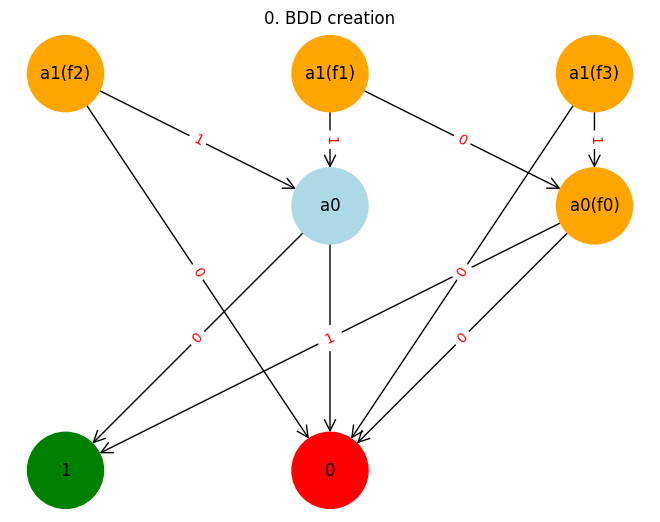

self.colMap {'EdgeNode_1': 0, 'EdgeNode_3': 1, 'EdgeNode_4': 2, 'EdgeNode_5': 3, 'EdgeNode_6': 4, 'EdgeNode_7': 5, 'EdgeNode_8': 6, 'EdgeNode_9': 7, 'EdgeNode_10': 8}
self.colMap1 {'EdgeNode_1': 0, 'EdgeNode_3': 1, 'EdgeNode_4': 3, 'EdgeNode_5': 2, 'EdgeNode_6': 4, 'EdgeNode_7': 5, 'EdgeNode_8': 6, 'EdgeNode_9': 7, 'EdgeNode_10': 8}
self.colMap {'EdgeNode_1': 0, 'EdgeNode_3': 1, 'EdgeNode_4': 3, 'EdgeNode_5': 2, 'EdgeNode_6': 4, 'EdgeNode_7': 5, 'EdgeNode_8': 6, 'EdgeNode_9': 7, 'EdgeNode_10': 8}
xlabelsOfLiterals ['a1', '~a1', '~a0', 'a1', 'a0', 'f2', 'f1', 'f3', 'f0', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16']


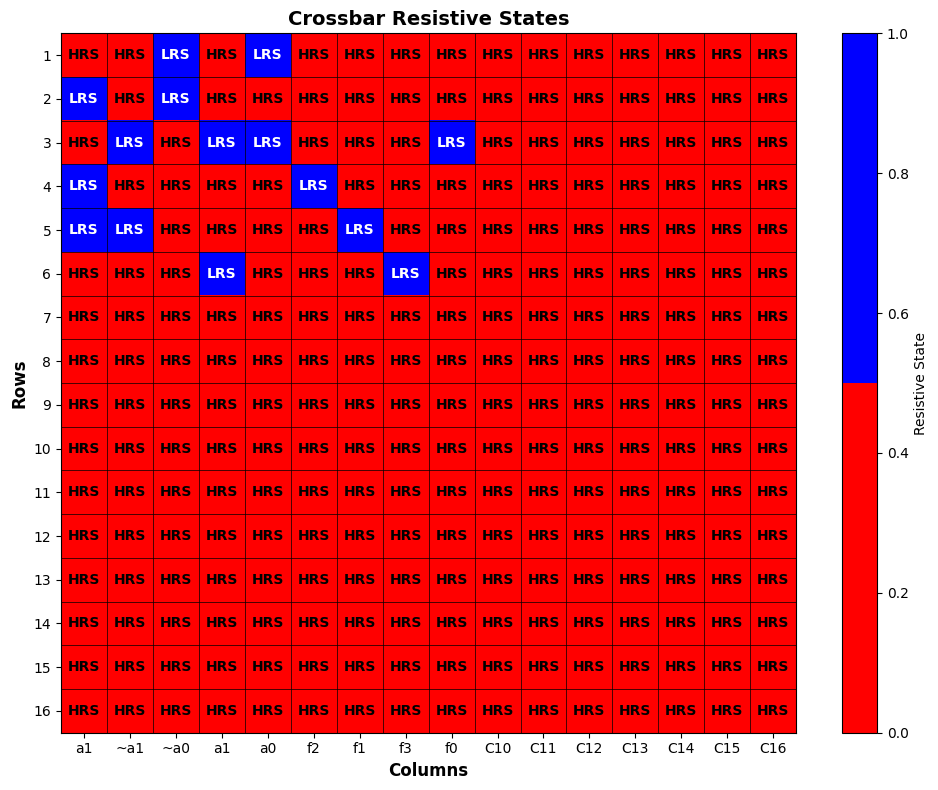

Verifying all ideal paths in the crossbar...
Crossbar verification completed. Total mismatches: 0
----------------------------------------------------------------------------------------------


In [25]:
Functional_Logic_Of_Path_Crossbar_Programings = {}

start_time = time.time()

truth_table = df
outputs = ["f3", "f2", "f1", "f0"]
filename, outputs, df = "bdds/Multiplier/2bitmultiplier2.sbdd", outputs, truth_table

adderbit = 1

path = PATH(CrossbarGridSize = 64)
# path.TruthTable_to_BooleanExpression(df, outputs=outputs)
# path.BooleanExpresions_to_BDD()
# print("----------------------------------------------------------------------------------------------")
# expressions = {'F0' : '(a & b) | (a & cin) | (b & cin)',
# 'F1' : '(a & b & cin) | (a & ~b & ~cin) | (b & ~a & ~cin) | (cin & ~a & ~b)'}
# variables = ['a', 'b', 'cin']
# path.SetBooleanExpressionsAndVaribles(variables = variables, expressions = expressions, outputs = list(expressions.keys()))
# print("----------------------------------------------------------------------------------------------")

path.SetBooleanExpressionsAndVaribles(variables = None, expressions = None, outputs = outputs, OriginalTruthTable=df)
path.parse_file_to_NetworkXGraph(filename)
path.BDD_to_NetworkXGraph()
path.Verify_BDD_to_NetworkXGraph(withExpression=False, withOriginalTruthTable=True)
path.VisuvaliseNetworkXGraph()
# print("----------------------------------------------------------------------------------------------")
path.GraphPreprocessing()
# # path.VisuvaliseNetworkXGraph()
# # print("----------------------------------------------------------------------------------------------")
path.GraphTransformation()
# # path.VisuvaliseNetworkXGraph(bipartite=True)
# # print("----------------------------------------------------------------------------------------------")
path.GraphCompression()
# # path.VisuvaliseNetworkXGraph(bipartite=True)
# # print("----------------------------------------------------------------------------------------------")
path.CrossbarRelalization()
path.VisuvaliseCrossbar()
path.Verify_All_Ideal_Paths_In_Crossbar()
# #niti
# print(path.OutputLine_Map)
# # print(path.SBDD_dimentions)
# print("num1paths",len(path.AllIdealPathOfCurrent.keys()))
Functional_Logic_Of_Path_Crossbar_Programings[str(adderbit)+'-multiplier'] = {'Crossbar':path.CrossbarResistiveStates, 'Bitlines':path.Bitlines, 'TruthTable':path.OriginalTruthTable, 'OutputLine_Map':path.OutputLine_Map, 'AdderBit':str(adderbit)+'-multiplier', 'SBDD (V x E)':path.SBDD_dimentions, 'AllIdealPathOfCurrent': path.AllIdealPathOfCurrent}
print("----------------------------------------------------------------------------------------------")

In [26]:
Functional_Logic_Of_Path_Crossbar_Programings

{'1-multiplier': {'Crossbar': [[0,
    0,
    1,
    0,
    1,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0,
    0],
   [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
   [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
  'Bitlines': ['a1',
   '~a1',
   '~a0',
   'a1',
   'a0',
   '

In [27]:
class AnalogTestingOfPathCrossbar:
    def __init__(self, Crossbar, Bitlines, TruthTable, OutputLine_Map, AllIdealPathOfCurrent=None):
        self.Crossbar = Crossbar
        self.Bitlines = Bitlines
        self.TruthTable = TruthTable
        self.OutputLabelsToBitlineIndexMap = {OutputLine_Map[key]:Bitlines.index(key) for key in OutputLine_Map}  #imp
        self.OutputBitlineIndexMapToLabels = {Bitlines.index(key):OutputLine_Map[key] for key in OutputLine_Map}
        self.AllIdealPathOfCurrent = AllIdealPathOfCurrent
        self.AdderNumDevicesToCurrents_Map = {}
        
        self.tempMatrix = None

    def four_sig_truncate(self, num):
        """
        Truncates a positive float 'num' to exactly 4 significant digits.
        For example:
          1.357371568 -> '1.357'
          4.69340734797519e-6 -> '4.693e-06'
        """
        if num == 0:
            return "0"  # edge case
        
        # Get sign and make num positive if it isn't
        sign = "-" if num < 0 else ""
        num = abs(num)
        
        # Find base-10 exponent (e.g., 1.357... => exp=0, 4.693e-6 => exp ~ -5, etc.)
        exp = math.floor(math.log10(num))
        
        # Scale to get leading digit(s) (mantissa >= 1 and < 10)
        # e.g., for 1.357..., mantissa ~ 1.357
        # for 4.693e-6, mantissa ~ 4.693
        mantissa = num / (10**exp)
        
        # We want 4 significant digits total.
        # Multiply by 10^(4 - 1) = 10^3 = 1000. Then truncate.
        # This will keep exactly 4 digits before the decimal, effectively.
        mantissa_scaled = int(mantissa * 1000)  # truncation, no rounding
        mantissa_trunc = mantissa_scaled / 1000.0
        
        # If mantissa_trunc became >= 10 (very edge case), adjust
        if mantissa_trunc >= 10:
            mantissa_trunc /= 10
            exp += 1
        
        # If exponent is in [–3, 3], we might prefer normal notation (like '1.234') 
        # but to stick to a consistent style, let's always use e-notation if exp != 0:
        if exp == 0:
            # Just attach the sign
            return f"{sign}{mantissa_trunc}"
        else:
            return f"{sign}{mantissa_trunc}e{exp:+d}"

    def initialiseCrossbar(self, input_assignment={}):
        CrossbarCopy = [row.copy() for row in self.Crossbar]
        # self.Bitline

        for col_j, bitline in enumerate(self.Bitlines):
            literal = bitline
            negation = True if literal[0]=='~' else False
            if(negation):
                literal=literal[1:]
            flag=True
            if('O' in literal):
                flag=False
            elif(literal in input_assignment and input_assignment[literal]==0):
                if(negation):
                    flag=False
            elif(literal in input_assignment and input_assignment[literal]==1):
                if(not negation):
                    flag=False
            if(flag):
                for row_i in range(len(CrossbarCopy)):
                    CrossbarCopy[row_i][col_j] = 2

        return CrossbarCopy

    # def NodalAnalysis(self, Initialized_Crossbar, variable_HRS, output_bitlines):
    #     """
    #     Performs a nodal (KCL) analysis on the given Initialized_Crossbar
    #     using variable_HRS as the high-resistance state (HRS).
        
    #     Returns:
    #         Output_current_map (dict): Maps each output line label to its computed current.
    #     """
    #     # print('variable_HRS',variable_HRS)
        
    #     # Define resistor parameters
    #     R_Off       = max(2e9,variable_HRS)        # Very large (transistor off)
    #     R_HRS       = variable_HRS # High-resistance state of the memory cell
    #     R_LRS       = 5000        # Low-resistance state
    #     R_Line_Out  = 2e2         # e.g., 200 ohms from each column node to GND
    #     R_Not       = max(2e9,variable_HRS)         # Large resistance for non-output columns
    
    #     # We'll use the user-provided crossbar as our base matrix of resistances
    #     Resitance_matrix = [row.copy() for row in Initialized_Crossbar]
    #     crossbar_size = len(Initialized_Crossbar)

    #     # Replace 0 with R_HRS and 1 with R_LRS
    #     for i in range(crossbar_size):
    #         for j in range(crossbar_size):
    #             if Resitance_matrix[i][j] == 0:
    #                 Resitance_matrix[i][j] = R_HRS
    #             elif Resitance_matrix[i][j] == 1:
    #                 Resitance_matrix[i][j] = R_LRS
    #             elif Resitance_matrix[i][j] == 2:
    #                 Resitance_matrix[i][j] = R_Off
                    
    #     # print('Resitance_matrix',Resitance_matrix[0])
        
    #     voltage_row_variables = " ".join(["Vr"+str(i) for i in range(1,crossbar_size+1)])
    #     voltage_col_variables = " ".join(["Vc"+str(i) for i in range(1,crossbar_size+1)])
        
    #     # ----------------------------------------------------------------
    #     # 1) Construct the system of equations for 8 row voltages + 8 column voltages
    #     # We'll define these symbolic variables:
    #     Vr = sympy.symbols(voltage_row_variables, real=True)
    #     Vc = sympy.symbols(voltage_col_variables, real=True)
    #     x_vars = list(Vr) + list(Vc)
    
    #     # Voltage source for the first row (example: 0.2V)
    #     Vsrc = 0.2
    
    #     equations = []
    #     # Build row equations
    #     for i in range(crossbar_size):
    #         if i == 0:
    #             # First word line connected to the voltage source
    #             eq_i = sympy.Eq(Vr[i], Vsrc)
    #         else:
    #             row_sum = 0
    #             for j in range(crossbar_size):
    #                 # KCL: sum of currents from row node i to each column node j
    #                 row_sum += (Vr[i] - Vc[j]) / Resitance_matrix[i][j]
    #             eq_i = sympy.Eq(row_sum, 0)
    #         equations.append(eq_i)

    #     # Build column equations
    #     for j in range(crossbar_size):
    #         # If this column is an output line, it goes to ground through R_Line_Out;
    #         if j in output_bitlines:
    #             col_to_ground = Vc[j] / R_Line_Out
    #         else:
    #             col_to_ground = Vc[j] / R_Not
            
    #         col_sum = 0
    #         for i in range(crossbar_size):
    #             col_sum += (Vc[j] - Vr[i]) / Resitance_matrix[i][j]
            
    #         eq_j = sympy.Eq(col_to_ground + col_sum, 0)
    #         equations.append(eq_j)
    
    #     # ----------------------------------------------------------------
    #     # 2) Solve the system A*x = b
    #     A, b = sympy.linear_eq_to_matrix(equations, x_vars)
    #     # solution = A.LUsolve(b)

    #     # Convert sympy Matrix A to a NumPy 2D array:
    #     A_np = np.array(A.tolist(), dtype=float)
        
    #     # Convert sympy Matrix b to a 1D or 2D NumPy array:
    #     b_np = np.array(b.tolist(), dtype=float)

    #     # If b_np is shape (n, 1), flatten to (n,):
    #     if b_np.ndim == 2 and b_np.shape[1] == 1:
    #         b_np = b_np.ravel()

    #     #numpy matrix solver
    #     # solution = np.linalg.solve(A_np, b_np)

    #     self.tempMatrix = [A_np, b_np]

    #     #Scipy sparce matrix solver
    #     A_sparse = sp.csr_matrix(A_np)
    #     solution = spla.spsolve(A_sparse, b_np)
    
    #     # Convert solution to a dictionary of evaluated voltages (in millivolts, for example)
    #     Voltages = {}
    #     for var, val in zip(x_vars, solution):
    #         Voltages[str(var)] = val * 1000  # mV if you want, else remove *1000
    #         # Voltages[str(var)] = val.evalf() * 1000  # mV if you want, else remove *1000
    
    #     # ----------------------------------------------------------------
    #     # 3) Compute currents through each resistor
    #     # currentInDevices[i][j] = (Vr_i - Vc_j) / R(i,j)
    #     currentInDevices = [[0.0 for _ in range(crossbar_size)] for _ in range(crossbar_size)]
    #     for i in range(crossbar_size):
    #         for j in range(crossbar_size):
    #             # Convert back from millivolts to volts if you multiplied by 1000
    #             Vr_i = Voltages[f"Vr{i+1}"] / 1000
    #             Vc_j = Voltages[f"Vc{j+1}"] / 1000
    #             currentInDevices[i][j] = (Vr_i - Vc_j) / Resitance_matrix[i][j]
    
    #     # ----------------------------------------------------------------
    #     # 4) Compute the output current for each labeled output and non-labled output
    #     Output_current_map = {}
    #     for col_idx in range(1,crossbar_size+1):
    #         Vc_col = Voltages[f"Vc{col_idx}"] / 1000
    #         if(col_idx-1 in output_bitlines):
    #             Output_current_map[col_idx-1]=Vc_col / R_Line_Out

    #     # print('output_bitlines',output_bitlines)
    #     # print('Output_current_map',Output_current_map)
    #     # print('end of nodal analysis')
    #     return Output_current_map

    def NodalAnalysis(self, Initialized_Crossbar, variable_HRS, output_bitlines):
        """
        Performs a nodal (KCL) analysis on the given Initialized_Crossbar
        using variable_HRS as the high-resistance state (HRS).
    
        Returns:
            Output_current_map (dict): Maps each output line label to its computed current.
        """
        # Define resistor parameters
        R_Off = max(1e9, variable_HRS)  # Very large (transistor off)
        R_HRS = variable_HRS  # High-resistance state of the memory cell
        # R_LRS = 5000  # Low-resistance state
        R_LRS = 2000  # Low-resistance state
        R_Line_Out = 200  # 200 ohms from each column node to GND
        R_Not = max(1e9, variable_HRS)  # Large resistance for non-output columns
    
        # Crossbar size
        crossbar_size = len(Initialized_Crossbar)

        # Convert the Initialized_Crossbar to a NumPy array
        Initialized_Crossbar = np.array(Initialized_Crossbar)
    
        # Proper element-wise replacement
        Resistance_matrix = np.where(Initialized_Crossbar == 0, R_HRS, 
                                    np.where(Initialized_Crossbar == 1, R_LRS, 
                                             np.where(Initialized_Crossbar == 2, R_Off, Initialized_Crossbar)))
    
        # Number of unknowns: row voltages + column voltages
        num_vars = 2 * crossbar_size  
        A = np.zeros((num_vars, num_vars))  # Coefficient matrix
        b = np.zeros(num_vars)  # Constant vector
    
        # Voltage source for the first row (0.2V)
        Vsrc = 0.2  
    
        # Define row equations (KCL)
        for i in range(crossbar_size):
            if i == 0:
                # First row is directly connected to the voltage source
                A[i, i] = 1
                b[i] = Vsrc
            else:
                for j in range(crossbar_size):
                    Rij = Resistance_matrix[i][j]
                    A[i, i] += 1 / Rij  # Self term
                    A[i, crossbar_size + j] -= 1 / Rij  # Interaction with column
    
        # Define column equations (KCL)
        for j in range(crossbar_size):
            if j in output_bitlines:
                R_ground = R_Line_Out  # If it's an output bitline, connects to ground through R_Line_Out
            else:
                R_ground = R_Not  # If not an output bitline, connect to ground through R_Not
    
            A[crossbar_size + j, crossbar_size + j] = 1 / R_ground  # Self term
            for i in range(crossbar_size):
                Rij = Resistance_matrix[i][j]
                A[crossbar_size + j, crossbar_size + j] += 1 / Rij  # Self term
                A[crossbar_size + j, i] -= 1 / Rij  # Interaction with row
    
        # Convert A to sparse matrix and solve Ax = b
        # A_sparse = sp.csr_matrix(A)
        # solution = spla.spsolve(A_sparse, b)

        #solve using numpy
        solution = np.linalg.solve(A, b)
    
        # Extract voltages
        Vr = solution[:crossbar_size]  # Row voltages
        Vc = solution[crossbar_size:]  # Column voltages
    
        # Compute currents through each resistor
        currentInDevices = (Vr[:, None] - Vc[None, :]) / Resistance_matrix
    
        # Compute the output currents
        Output_current_map = {j: Vc[j] / R_Line_Out for j in output_bitlines}
    
        return Output_current_map
        
    def Iteration_Of_Each_Row_In_the_TruthTable(self, variable_HRS):

        output_cols = list(self.OutputLabelsToBitlineIndexMap.keys())
        input_columns = [col for col in self.TruthTable.columns if col not in output_cols]  # Variables
        output_columns = [col for col in self.TruthTable.columns if col in output_cols]  # Expressions (functions)

        zerosCurrents, onesCurrents = [], []
        # Iterate over each row in the truth table
        for idx, row in self.TruthTable.iterrows():
            input_assignment = {var: int(row[var]) for var in input_columns}  # Convert inputs to dictionary {'a0':0, 'b0':0, 'cin':1}
            expected_outputs = {expr: int(row[expr]) for expr in output_columns}  # Expected output values

            start_time_iteration = time.time()
            
            #setting selector lines -> crossbar matrix
            Initialized_Crossbar = self.initialiseCrossbar(input_assignment)

            #running nodal analysis -> current in each bitlines
            currentOutputs = self.NodalAnalysis(Initialized_Crossbar, variable_HRS, output_bitlines=self.OutputLabelsToBitlineIndexMap.values())
            # print('currentOutputs',currentOutputs)

            # newcurrentOutputs = {self.OutputBitlineIndexMapToLabels[key]:self.four_sig_truncate(currentOutputs[key]) for key in currentOutputs}
            newcurrentOutputs = {self.OutputBitlineIndexMapToLabels[key]:currentOutputs[key] for key in currentOutputs}

            # print('expected_outputs',expected_outputs, "Duration:", self.four_sig_truncate(time.time()-start_time_iteration),"sec")
            # print('newcurrentOutputs',newcurrentOutputs)
            
            # check min and max curretns at expected_outputs using this AnalogPathTest.OutputLabelsToBitlineIndexMap
            for label in expected_outputs:
                outputCurrent = newcurrentOutputs[label]
                if(expected_outputs[label]==0):
                    zerosCurrents.append(outputCurrent)
                elif(expected_outputs[label]==1):
                    onesCurrents.append(outputCurrent)
                    numberofDevices = AllIdealPathOfCurrent[frozenset(input_assignment.items())][label]["lengthOfDevices"]
                    if(numberofDevices not in self.AdderNumDevicesToCurrents_Map):
                        self.AdderNumDevicesToCurrents_Map[numberofDevices] = []
                    self.AdderNumDevicesToCurrents_Map[numberofDevices].append(outputCurrent)

        guardBand = min(onesCurrents) - max(zerosCurrents)
        return {"guardBand":guardBand, "zerosCurrents":zerosCurrents, "onesCurrents":onesCurrents}

    def Iteration_Of_sufficient_Rows_In_the_TruthTable(self, variable_HRS):
        output_cols = list(self.OutputLabelsToBitlineIndexMap.keys())
        input_columns = [col for col in self.TruthTable.columns if col not in output_cols]  # Variables
        output_columns = [col for col in self.TruthTable.columns if col in output_cols]  # Expressions (functions)

        zerosCurrents, onesCurrents = [], []
        #find scenarios(cases) that have minimal current in 1's and max current in 0's
        #Test only for those cases until 11-bit adder

        guardBand = min(onesCurrents) - max(zerosCurrents)
        return {"guardBand":guardBand, "zerosCurrents":zerosCurrents, "onesCurrents":onesCurrents}
        

    def Finding_optimal_HRS_using_binarysearch(self, high_variable_HRS=2e9, iterations=2, optimisation=False):
        """
        Perform a binary search to find an optimal high-resistance value (HRS)
        that yields a positive guardValue returned by 'Iteration_Of_Each_Row_In_the_TruthTable'.
        
        Params:
            high_variable_HRS (float): Upper bound for HRS (defaults to 2e9).
            iterations (int): Number of binary search iterations.
    
        Returns:
            float: The last HRS value that produced a positive guardValue, if any.
        """
        lower_bound = 0.0
        upper_bound = high_variable_HRS
    
        guard_values = []
        resistance_values = []
        zerosCurrents_lst = []
        onesCurrents_lst = []
    
        for i in range(iterations):
            # Midpoint of the current lower and upper bounds
            resistance_value = (lower_bound + upper_bound) / 2

            print('resistance_value',resistance_value)

            start_time_all_iterations = time.time()

            if(optimisation):
                guardbandMap = self.Iteration_Of_sufficient_Rows_In_the_TruthTable(resistance_value)
            else:
                guardbandMap = self.Iteration_Of_Each_Row_In_the_TruthTable(resistance_value)

            guardband, zerosCurrents, onesCurrents = guardbandMap['guardBand'], guardbandMap['zerosCurrents'], guardbandMap['onesCurrents']
            print('guardBand',guardband, 'Total Duration =',self.four_sig_truncate(time.time()-start_time_all_iterations),"sec")
            print('-----------------------------------')
            # Decide which way to move in the binary search
            if guardband > 0:
                # If guardband is positive, it means we can try smaller high-resistance
                upper_bound = resistance_value
                guard_values.append(guardband)
                resistance_values.append(resistance_value)
                zerosCurrents_lst.append(zerosCurrents)
                onesCurrents_lst.append(onesCurrents)
            else:
                # Otherwise, we need to go higher
                lower_bound = resistance_value

        return {"guardbands":guard_values, "resistance_values":resistance_values, "zerosCurrents_lst":zerosCurrents_lst, "onesCurrents_lst":onesCurrents_lst}

In [28]:
Functional_Logic_Of_Path_Crossbar_Programings = {'1-multiplier': 
    {'Crossbar': [
   [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
   [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    ],
  'Bitlines': ['a1', '~a1', '~a0', 'a1', 'a0', 'O7', 'O8', 'O9', 'O10', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16'],
  'TruthTable':   df,
  'OutputLine_Map': {'O7': 'f2', 'O8': 'f1', 'O9': 'f3', 'O10': 'f0'},
  'AdderBit': '1-multiplier',
  'SBDD (V x E)': '9 x 6',
  'AllIdealPathOfCurrent': {frozenset({('a0', 1),
              ('a1',
               0)}): {'f1': {'lengthOfDevices': 5}, 'f0': {'lengthOfDevices': 3}},
   frozenset({('a0', 0), ('a1', 1)}): {'f2': {'lengthOfDevices': 5},
    'f1': {'lengthOfDevices': 5}},
   frozenset({('a0', 1), ('a1', 1)}): {'f3': {'lengthOfDevices': 5},
    'f0': {'lengthOfDevices': 3}}}}}

In [ ]:
Functional_Logic_Of_Path_Crossbar_Programings = {'1-multiplier': 
    {'Crossbar': [
   [1, 0, 0, 1, 0, 0, 0, 0],
   [0, 0, 1, 1, 0, 0, 0, 0],
   [0, 1, 1, 0, 0, 1, 0, 0],
   [1, 1, 0, 0, 0, 0, 0, 1],
   [1, 0, 0, 0, 1, 0, 0, 0],
   [0, 0, 1, 0, 0, 0, 1, 0],
   [0, 0, 0, 0, 0, 0, 0, 0],
   [0, 0, 0, 0, 0, 0, 0, 0],
    ],
  'Bitlines': ['a0', '~a1', 'a1', '~a0', 'O7', 'O8', 'O9', 'O10(a1)', 'C10', 'C11', 'C12', 'C13', 'C14', 'C15', 'C16'],
  'TruthTable':   df,
  'OutputLine_Map': {'O7': 'f0', 'O8': 'f1', 'O9': 'f1', 'O10(a1)': 'f3'},
  'AdderBit': '1-multiplier',
  'SBDD (V x E)': '9 x 6',
  'AllIdealPathOfCurrent': {frozenset({('a0', 1),
              ('a1',
               0)}): {'f1': {'lengthOfDevices': 5}, 'f0': {'lengthOfDevices': 3}},
   frozenset({('a0', 0), ('a1', 1)}): {'f2': {'lengthOfDevices': 5},
    'f1': {'lengthOfDevices': 5}},
   frozenset({('a0', 1), ('a1', 1)}): {'f3': {'lengthOfDevices': 5},
    'f0': {'lengthOfDevices': 3}}}}}

In [29]:
Adder_guardbandsVsReistancesDetailsMaps = {}
Functional_Logic_Of_Path_Crossbar_Programings_keys = list(Functional_Logic_Of_Path_Crossbar_Programings.keys())
start = 0
iterations = 8
for i in range(start, len(Functional_Logic_Of_Path_Crossbar_Programings_keys)):
    adderName = Functional_Logic_Of_Path_Crossbar_Programings_keys[i]
    Functional_Logic_Of_Path_Crossbar_Programing_map = Functional_Logic_Of_Path_Crossbar_Programings[adderName]
    
    start_time = time.time()
    start_dt = datetime.datetime.fromtimestamp(start_time)

    n = len(Functional_Logic_Of_Path_Crossbar_Programing_map['Crossbar'])
    print(f"processing {adderName}. Crossbar dim.:{n}x{n} Started on {start_dt.strftime('%Y-%m-%d %H:%M:%S')}")
    Crossbar = Functional_Logic_Of_Path_Crossbar_Programing_map['Crossbar']
    Bitlines = Functional_Logic_Of_Path_Crossbar_Programing_map['Bitlines']
    TruthTable = Functional_Logic_Of_Path_Crossbar_Programing_map['TruthTable']
    OutputLine_Map = Functional_Logic_Of_Path_Crossbar_Programing_map['OutputLine_Map']
    SBDD_dimentions = Functional_Logic_Of_Path_Crossbar_Programing_map['SBDD (V x E)']
    AllIdealPathOfCurrent = Functional_Logic_Of_Path_Crossbar_Programing_map['AllIdealPathOfCurrent']
    
    AnalogPathTest = AnalogTestingOfPathCrossbar(Crossbar=Crossbar, Bitlines=Bitlines, TruthTable=TruthTable, OutputLine_Map=OutputLine_Map, AllIdealPathOfCurrent=AllIdealPathOfCurrent)

    optimisation = i>4
    
    guardbandsVsReistancesMap = AnalogPathTest.Finding_optimal_HRS_using_binarysearch(high_variable_HRS=2e6, iterations=iterations, optimisation=optimisation)
    
    Adder_guardbandsVsReistancesDetailsMaps[Functional_Logic_Of_Path_Crossbar_Programing_map['AdderBit']] = guardbandsVsReistancesMap

    
    # Calculating average current passing thing through number of devices
    AdderNumDevicesToAvgCurrent_Map = {}
    for numOfDevices in AnalogPathTest.AdderNumDevicesToCurrents_Map.keys():
        AdderNumDevicesToAvgCurrent_Map[numOfDevices] = sum(AnalogPathTest.AdderNumDevicesToCurrents_Map[numOfDevices])/len(AnalogPathTest.AdderNumDevicesToCurrents_Map[numOfDevices])
    # print('AdderNumDevicesToAvgCurrent_Map',AdderNumDevicesToAvgCurrent_Map)
    Adder_guardbandsVsReistancesDetailsMaps[Functional_Logic_Of_Path_Crossbar_Programing_map['AdderBit']]["AdderNumDevicesToAvgCurrent_Map"] = AdderNumDevicesToAvgCurrent_Map
    Adder_guardbandsVsReistancesDetailsMaps[Functional_Logic_Of_Path_Crossbar_Programing_map['AdderBit']]["AdderNumDevicesToCurrents_Map"] = AnalogPathTest.AdderNumDevicesToCurrents_Map
    
    
    AdderFrequencyOfNumDevices = {}
    for entry in Functional_Logic_Of_Path_Crossbar_Programings[str(i+1)+'-multiplier']['AllIdealPathOfCurrent'].values():
        for key in entry:
            length = entry[key]['lengthOfDevices']
            if length in AdderFrequencyOfNumDevices:
                AdderFrequencyOfNumDevices[length] += 1
            else:
                AdderFrequencyOfNumDevices[length] = 1
    # Adder_guardbandsVsReistancesDetailsMaps[Functional_Logic_Of_Path_Crossbar_Programing_map['AdderBit']]["AdderFrequencyOfNumDevices"] = length_frequency

    
    
    #Get duration of total time for all the iterations
    iteration_time = time.time() - start_time
    Adder_guardbandsVsReistancesDetailsMaps[Functional_Logic_Of_Path_Crossbar_Programing_map['AdderBit']]["Duration"] = iteration_time
    print()
    print(f"{adderName} Enumeration NA analysis took {iteration_time:.6f} seconds")
    if(i==3):
        break

# Save (pickle) to a file
with open("Data/Adder_guardbandsVsReistancesDetailsMaps.pkl", "wb") as f:
    pickle.dump(Adder_guardbandsVsReistancesDetailsMaps, f)

print("Data saved to Data/Adder_guardbandsVsReistancesDetailsMaps.pkl")

processing 1-multiplier. Crossbar dim.:16x16 Started on 2025-02-28 22:23:12
resistance_value 1000000.0
guardBand 8.343539809097209e-06 Total Duration = 3.005e-3 sec
-----------------------------------
resistance_value 500000.0
guardBand 7.4869503185961105e-06 Total Duration = 2.099e-3 sec
-----------------------------------
resistance_value 250000.0
guardBand 6.054643955369012e-06 Total Duration = 3.007e-3 sec
-----------------------------------
resistance_value 125000.0
guardBand 4.015886763314206e-06 Total Duration = 2.894e-3 sec
-----------------------------------
resistance_value 62500.0
guardBand 1.8605908540143315e-06 Total Duration = 3.092e-3 sec
-----------------------------------
resistance_value 31250.0
guardBand -5.18757136811862e-08 Total Duration = 3.005e-3 sec
-----------------------------------
resistance_value 46875.0
guardBand 1.1857483783866691e-06 Total Duration = 1.897e-3 sec
-----------------------------------
resistance_value 39062.5
guardBand 7.177256535618333e-0

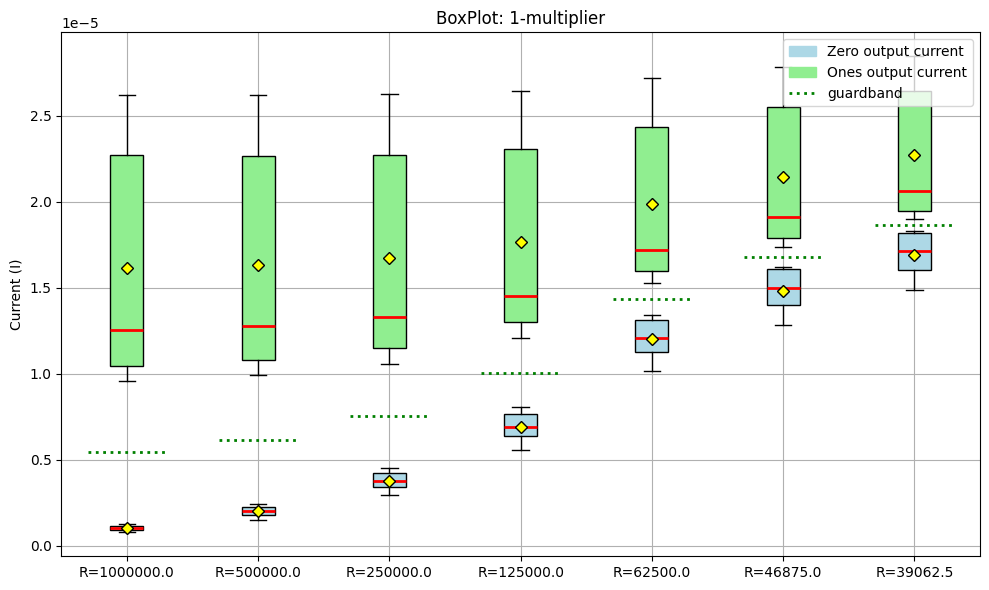

In [30]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


with open("Data/Adder_guardbandsVsReistancesDetailsMaps.pkl", "rb") as f:
    Adder_guardbandsVsReistancesDetailsMaps = pickle.load(f)

Adder_guardbandsVsReistancesDetailsMaps_keys = list(Adder_guardbandsVsReistancesDetailsMaps.keys())
for i in range(len(Adder_guardbandsVsReistancesDetailsMaps_keys)):
    key_adder = Adder_guardbandsVsReistancesDetailsMaps_keys[i]
    Adder_guardbandsVsReistancesDetailsMap = Adder_guardbandsVsReistancesDetailsMaps[key_adder]

    dataZeros = []
    dataOnes = []
    group_labels = []
    
    # Positions for each group
    pos = []
    guardband_values = []

    len_record_details = len(Adder_guardbandsVsReistancesDetailsMap["guardbands"])
    
    for j in range(len_record_details):
        dataZeros.append(Adder_guardbandsVsReistancesDetailsMap["zerosCurrents_lst"][j])
        dataOnes.append(Adder_guardbandsVsReistancesDetailsMap["onesCurrents_lst"][j])
        group_labels.append("R="+str(Adder_guardbandsVsReistancesDetailsMap["resistance_values"][j]))

        guardband_values.append(max(Adder_guardbandsVsReistancesDetailsMap["zerosCurrents_lst"][j])+(Adder_guardbandsVsReistancesDetailsMap["guardbands"][j]/2))
    
        pos.append(j+1)

    if(pos):

        plt.figure(figsize=(10, 6))
    
        
        # Plot dataZeros
        bp_zeros = plt.boxplot(
            dataZeros, 
            positions=pos, 
            patch_artist=True, 
            widths=0.25,             # Adjust width as desired
            showmeans=True,          
            boxprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            medianprops=dict(color='red', linewidth=2),
            meanprops=dict(marker='D', markeredgecolor='black', markerfacecolor='yellow')
        )
        
        # Color the boxes (dataZeros)
        for patch in bp_zeros['boxes']:
            patch.set_facecolor('lightblue')
        
        # Plot dataOnes
        bp_ones = plt.boxplot(
            dataOnes, 
            positions=pos, 
            patch_artist=True, 
            widths=0.25,
            showmeans=True,
            boxprops=dict(color='black'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            medianprops=dict(color='red', linewidth=2),
            meanprops=dict(marker='D', markeredgecolor='black', markerfacecolor='yellow')
        )
    
        # Add green dotted lines based on each group's guardband value
        for j, guardband_value in enumerate(guardband_values):
            # We'll draw a short line around x_val (from x_val-0.3 to x_val+0.3):
            plt.hlines(
                y=guardband_value,
                xmin=pos[j]-0.3,
                xmax=pos[j]+0.3,
                colors='green',
                linestyles='dotted',
                linewidth=2
            )
        
        # Color the boxes (dataOnes)
        for patch in bp_ones['boxes']:
            patch.set_facecolor('lightgreen')
        
        # Move x-ticks to the midpoint between the two boxplots of each group
        plt.xticks(pos, group_labels)
        
        plt.ylabel("Current (I)")
        plt.title("BoxPlot: "+key_adder)
        plt.grid(True)
        
        # Create legend elements
        zero_patch = mpatches.Patch(color='lightblue', label='Zero output current')
        one_patch = mpatches.Patch(color='lightgreen', label='Ones output current')
        guardband_line = mlines.Line2D([], [], color='green', linestyle='dotted', linewidth=2, label='guardband')
    
        plt.legend(handles=[zero_patch, one_patch, guardband_line], loc='upper right')
        
        plt.tight_layout()
        plt.show()

In [31]:
# Extract relevant data
guardbands = Adder_guardbandsVsReistancesDetailsMaps['1-multiplier']['guardbands']
resistances = Adder_guardbandsVsReistancesDetailsMaps['1-multiplier']['resistance_values']
min_ones = [min(lst) for lst in Adder_guardbandsVsReistancesDetailsMaps['1-multiplier']['onesCurrents_lst']]
max_zeros = [max(lst) for lst in Adder_guardbandsVsReistancesDetailsMaps['1-multiplier']['zerosCurrents_lst']]

# Create DataFrame
df = pd.DataFrame({
    'Guardband': guardbands,
    'Resistance': resistances,
    'Min Ones Current': min_ones,
    'Max Zeros Current': max_zeros
})

df

Guardband  Resistance  Min Ones Current  Max Zeros Current
0  8.343540e-06   1000000.0          0.000010           0.000001
1  7.486950e-06    500000.0          0.000010           0.000002
2  6.054644e-06    250000.0          0.000011           0.000005
3  4.015887e-06    125000.0          0.000012           0.000008
4  1.860591e-06     62500.0          0.000015           0.000013
5  1.185748e-06     46875.0          0.000017           0.000016
6  7.177257e-07     39062.5          0.000019           0.000018